In [1]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy

2022-12-02 19:43:37.919811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 19:43:39.279485: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/users/skoka/.conda/envs/ml_env_2/lib/
2022-12-02 19:43:39.279611: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/users/skoka/.conda/envs/ml_env_2/lib/
2022-12-02 19:43:39.279620: W tensorflow/c

In [2]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-12-02 19:43:42.611669: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 19:43:43.381117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 30971 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


True

In [3]:
strategy = tf.distribute.MirroredStrategy()

# Print the number of devices in the strategy's MirroredStrategy object
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

2022-12-02 19:43:43.403132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30971 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


# Evaluation Metric:

Accuracy:
Because the classes in our dataset are balanced, and there is no added benefit (from a buisness perspective) for our model to better predict one of the classes than the others, Accuracy is a good metric to use to judge our models 

## Loading in the Data:

In [4]:
files = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5", "test_batch"]
dir = "cifar-10-batches-py/"

# Loading the data into a single numpy array:
for file in files:
    with open(dir + file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        if file == "data_batch_1":
            data = dict[b'data']
            labels = dict[b'labels']
        else:
            data = np.vstack((data, dict[b'data']))
            labels = np.hstack((labels, dict[b'labels']))



data = data.reshape((data.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1).astype("int")

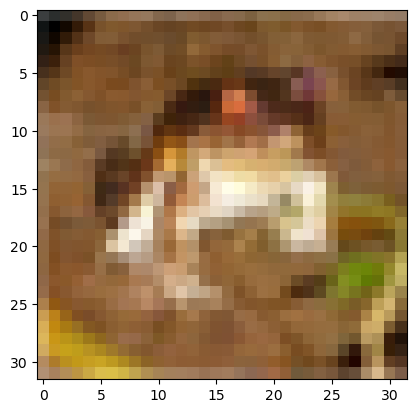

In [5]:
# plot the first image of cifar 10 dataset:
plt.imshow(data[0], interpolation='nearest')

# Splitting the Data:

We will use a stratified train test split. We have enough data, 60,000 images equally split amoungst 10 classes. Therefore, we do not need to use K-fold cross validation or shuffle split in order to properly train and evaluate our models.


In [6]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=69, stratify=labels)

# Modeling

In [7]:
def plot_history(history):
    # plot history of the model:
    fig = plt.figure(figsize=(10, 8))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validate')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')

## Model 1:

In [8]:
datagen = ImageDataGenerator()
datagen.fit(X_train)
input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(normalized_input)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
dense = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(64, activation='relu')(dense)
dense = tf.keras.layers.Dense(16, activation='relu')(dense)
output = tf.keras.layers.Dense(10, activation='softmax')(dense)
model1 = tf.keras.Model(inputs=input, outputs=output)

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history1 = model1.fit(datagen.flow(X_train, y_train, batch_size=256), epochs=20, validation_data=(X_val, y_val))

2022-12-01 14:40:22.799818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 14:40:22.799960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 14:40:22.800053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 14:40:22.800259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 14:40:22.800364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Epoch 1/20


2022-12-01 14:40:24.099616: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-12-01 14:40:25.383211: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-01 14:40:25.384109: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-12-01 14:40:25.384119: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-12-01 14:40:25.384543: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

188/188 [==============================] - 6s 13ms/step - loss: 1.9605 - accuracy: 0.2755 - val_loss: 1.6611 - val_accuracy: 0.3907
Epoch 2/20
188/188 [==============================] - 2s 11ms/step - loss: 1.5020 - accuracy: 0.4520 - val_loss: 1.4118 - val_accuracy: 0.4833
Epoch 3/20
188/188 [==============================] - 2s 11ms/step - loss: 1.3396 - accuracy: 0.5110 - val_loss: 1.3385 - val_accuracy: 0.5088
Epoch 4/20
188/188 [==============================] - 2s 11ms/step - loss: 1.2517 - accuracy: 0.5424 - val_loss: 1.2760 - val_accuracy: 0.5368
Epoch 5/20
188/188 [==============================] - 2s 11ms/step - loss: 1.1884 - accuracy: 0.5685 - val_loss: 1.2168 - val_accuracy: 0.5603
Epoch 6/20
188/188 [==============================] - 2s 11ms/step - loss: 1.1384 - accuracy: 0.5881 - val_loss: 1.1849 - val_accuracy: 0.5708
Epoch 7/20
188/188 [==============================] - 2s 11ms/step - loss: 1.0975 - accuracy: 0.6028 - val_loss: 1.1622 - val_accuracy: 0.5757
Epoch 8/20

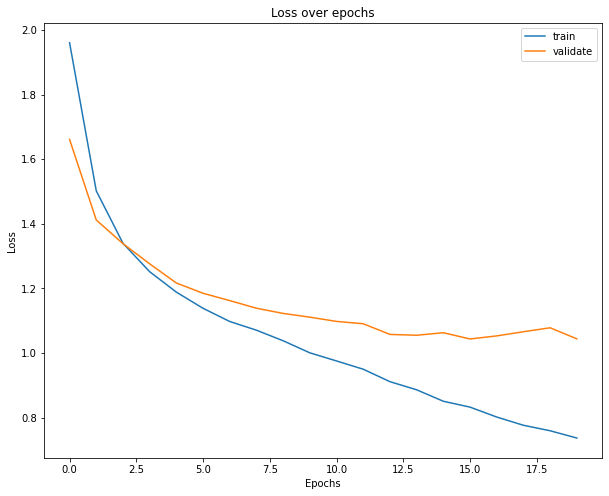

In [9]:
# plot the accuracy and loss of the model:
plot_history(history1)

As seen by the diverging train and validation loss graphs, the model is overfitting and validation accuracy is maxing out at around 62% while the training accuracy peaks at around 74%. In order to combat this we will add dropout in the next model to prevent overfitting.

## Model 1.5

In [10]:
datagen = ImageDataGenerator(rotation_range=5)
datagen.fit(X_train)
input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(normalized_input)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
dense = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(64, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)
dense = tf.keras.layers.Dense(16, activation='relu')(dense)
output = tf.keras.layers.Dense(10, activation='softmax')(dense)
model1_5 = tf.keras.Model(inputs=input, outputs=output)

model1_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history1_5 = model1_5.fit(datagen.flow(X_train, y_train, batch_size=256), epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
188/188 [==============================] - 9s 46ms/step - loss: 1.9369 - accuracy: 0.2719 - val_loss: 1.6564 - val_accuracy: 0.3946
Epoch 2/30
188/188 [==============================] - 8s 45ms/step - loss: 1.5762 - accuracy: 0.4176 - val_loss: 1.4409 - val_accuracy: 0.4915
Epoch 3/30
188/188 [==============================] - 8s 44ms/step - loss: 1.4644 - accuracy: 0.4646 - val_loss: 1.3823 - val_accuracy: 0.5231
Epoch 4/30
188/188 [==============================] - 8s 44ms/step - loss: 1.3933 - accuracy: 0.4928 - val_loss: 1.3278 - val_accuracy: 0.5366
Epoch 5/30
188/188 [==============================] - 8s 45ms/step - loss: 1.3552 - accuracy: 0.5075 - val_loss: 1.2960 - val_accuracy: 0.5548
Epoch 6/30
188/188 [==============================] - 8s 44ms/step - loss: 1.3048 - accuracy: 0.5254 - val_loss: 1.2387 - val_accuracy: 0.5648
Epoch 7/30
188/188 [==============================] - 8s 44ms/step - loss: 1.2707 - accuracy: 0.5399 - val_loss: 1.2463 - val_accuracy: 0.5614

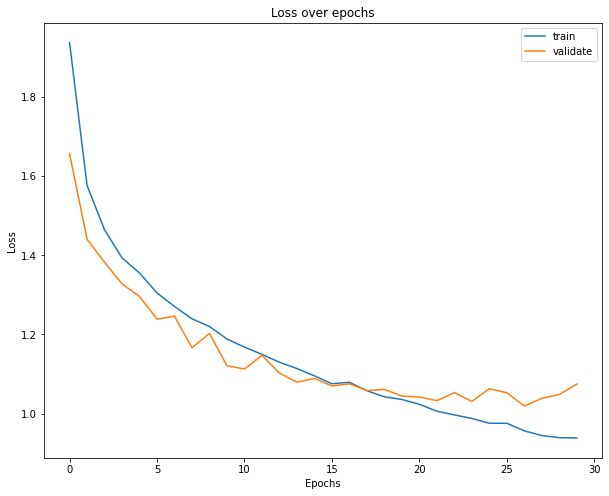

In [11]:
plot_history(history1_5)

## McNemar Test to test differences between model1 and model1_5

In [12]:
y_pred_model1 = model1.predict(X_val)
y_pred_model1_5 = model1_5.predict(X_val)

y_pred_model1 = np.argmax(y_pred_model1, axis=1)
y_pred_model1_5 = np.argmax(y_pred_model1_5, axis=1)


model1_correct = np.sum((y_pred_model1 == y_val) & (y_pred_model1_5 != y_val))
model1_5_correct = np.sum((y_pred_model1_5 == y_val) & (y_pred_model1 != y_val))

critical_value = (model1_correct + model1_5_correct)**2 / (model1_correct + model1_5_correct)
from scipy.stats import chi2
import math

p = 1 - chi2.cdf(math.sqrt(critical_value), 1)


In [13]:
p

1.0897949209720537e-12

## Model 2:

In [14]:
datagen = ImageDataGenerator()
datagen.fit(X_train)
input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(normalized_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)

dense = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(32, activation='relu')(dense)
output = tf.keras.layers.Dense(10, activation='softmax')(dense)

model2 = tf.keras.Model(inputs=input, outputs=output)

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

history2 = model2.fit(datagen.flow(X_train, y_train, batch_size=512), epochs=35, validation_data=(X_val, y_val))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 16)       64        
 ormalization)                                                   
                                                                 
 dropout_2 (Dropout)         (None, 30, 30, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        2320      
                                                           

In [15]:
model2.save('model2.h5')

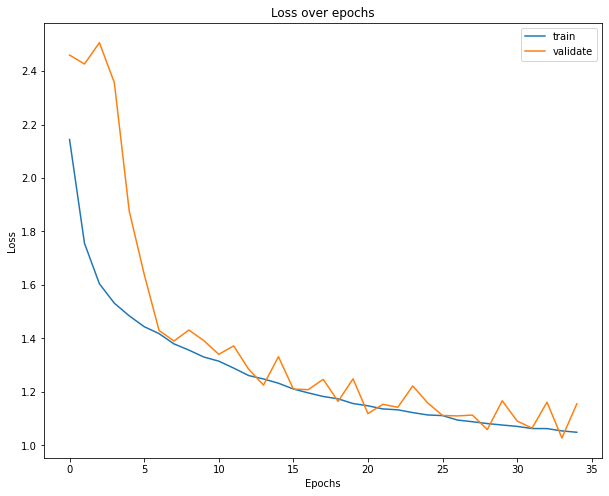

In [16]:
plot_history(history2)

## Model 2.5:

In [17]:
datagen = ImageDataGenerator()
datagen.fit(X_train)
input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(normalized_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)

dense = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(64, activation='relu')(dense)
output = tf.keras.layers.Dense(10, activation='softmax')(dense)

model2_5 = tf.keras.Model(inputs=input, outputs=output)

model2_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history2_5 = model2_5.fit(datagen.flow(X_train, y_train, batch_size=512), epochs=35, validation_data=(X_val, y_val))

Epoch 1/35
94/94 [==============================] - 27s 257ms/step - loss: 2.2062 - accuracy: 0.1598 - val_loss: 2.8444 - val_accuracy: 0.1004
Epoch 2/35
94/94 [==============================] - 21s 227ms/step - loss: 1.7550 - accuracy: 0.3327 - val_loss: 2.2287 - val_accuracy: 0.1538
Epoch 3/35
94/94 [==============================] - 21s 228ms/step - loss: 1.5252 - accuracy: 0.4312 - val_loss: 2.5574 - val_accuracy: 0.1171
Epoch 4/35
94/94 [==============================] - 21s 228ms/step - loss: 1.3495 - accuracy: 0.5084 - val_loss: 2.5376 - val_accuracy: 0.1390
Epoch 5/35
94/94 [==============================] - 21s 228ms/step - loss: 1.2203 - accuracy: 0.5588 - val_loss: 1.9589 - val_accuracy: 0.2702
Epoch 6/35
94/94 [==============================] - 21s 228ms/step - loss: 1.1308 - accuracy: 0.5945 - val_loss: 1.7149 - val_accuracy: 0.3666
Epoch 7/35
94/94 [==============================] - 22s 229ms/step - loss: 1.0683 - accuracy: 0.6190 - val_loss: 1.3031 - val_accuracy: 0.5372

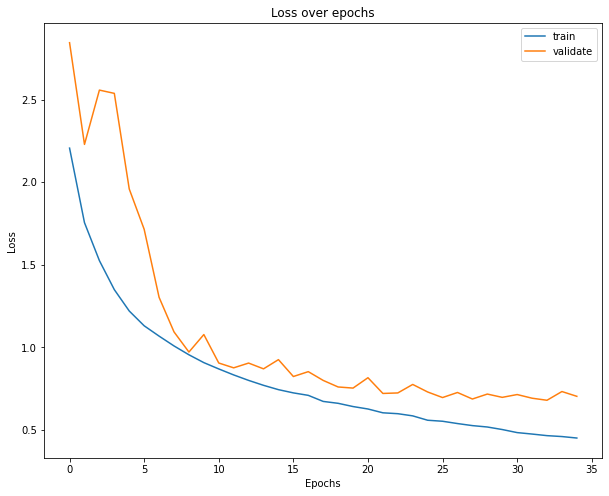

In [18]:
plot_history(history2_5)

## Model 3:


Inspired by: 
https://arxiv.org/pdf/1512.03385.pdf

In [29]:
from tensorflow.keras.regularizers import l2

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
)

datagen.fit(X_train)
    

# Resnet block:

def resnet_block(input, output_filters, strides=1):
    input_filters = input.shape[-1]
    if input_filters != output_filters:
        new_add = tf.keras.layers.Conv2D(output_filters, (1, 1), activation='relu', strides=strides)(input)
    x = tf.keras.layers.Conv2D(output_filters, (3,3), padding="same", strides=strides)(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(output_filters, (3,3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if input_filters != output_filters:
        x = tf.keras.layers.Add()([x, new_add])
    else:
        x = tf.keras.layers.Add()([x, input])
    x = tf.keras.layers.Activation('relu')(x)
    return x

input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

x = tf.keras.layers.Conv2D(16, (7, 7), activation='relu')(normalized_input)
x = tf.keras.layers.BatchNormalization()(x)

# resnet block
x = resnet_block(x, 16)
x = resnet_block(x, 16)
x = resnet_block(x, 16)
x = resnet_block(x, 32, 2)
x = resnet_block(x, 32)
x = resnet_block(x, 32)
x = resnet_block(x, 64, 2)
x = resnet_block(x, 64)
x = resnet_block(x, 64)

x = tf.keras.layers.MaxPooling2D((2, 2))(x)
dense = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(10, activation='softmax')(dense)

model3 = tf.keras.Model(inputs=input, outputs=output)

model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_15 (Rescaling)       (None, 32, 32, 3)    0           ['input_16[0][0]']               
                                                                                                  
 conv2d_199 (Conv2D)            (None, 30, 30, 256)  7168        ['rescaling_15[0][0]']           
                                                                                                  
 batch_normalization_121 (Batch  (None, 30, 30, 256)  1024       ['conv2d_199[0][0]']             
 Normalization)                                                                             

                                                                                                  
 conv2d_210 (Conv2D)            (None, 15, 15, 32)   9248        ['activation_152[0][0]']         
                                                                                                  
 batch_normalization_130 (Batch  (None, 15, 15, 32)  128         ['conv2d_210[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_153 (Activation)    (None, 15, 15, 32)   0           ['batch_normalization_130[0][0]']
                                                                                                  
 conv2d_211 (Conv2D)            (None, 15, 15, 32)   9248        ['activation_153[0][0]']         
                                                                                                  
 batch_nor

 add_84 (Add)                   (None, 8, 8, 64)     0           ['batch_normalization_139[0][0]',
                                                                  'activation_160[0][0]']         
                                                                                                  
 activation_162 (Activation)    (None, 8, 8, 64)     0           ['add_84[0][0]']                 
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 4, 4, 64)    0           ['activation_162[0][0]']         
                                                                                                  
 flatten_6 (Flatten)            (None, 1024)         0           ['max_pooling2d_6[0][0]']        
                                                                                                  
 dense_8 (Dense)                (None, 10)           10250       ['flatten_6[0][0]']              
          

In [ ]:
# Train the model
history3 = model3.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
1500/1500 [==============================] - 29s 13ms/step - loss: 1.6103 - accuracy: 0.4416 - val_loss: 1.3553 - val_accuracy: 0.5234
Epoch 2/20
1500/1500 [==============================] - 18s 12ms/step - loss: 1.1081 - accuracy: 0.6149 - val_loss: 1.1500 - val_accuracy: 0.5960
Epoch 3/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.8682 - accuracy: 0.6981 - val_loss: 0.8874 - val_accuracy: 0.6848
Epoch 4/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.7237 - accuracy: 0.7499 - val_loss: 0.9113 - val_accuracy: 0.6917
Epoch 5/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.6165 - accuracy: 0.7865 - val_loss: 0.9238 - val_accuracy: 0.6972
Epoch 6/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.5308 - accuracy: 0.8156 - val_loss: 1.0295 - val_accuracy: 0.6752
Epoch 7/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.4571 - accuracy: 0.8406 - val_loss: 0.6832 -

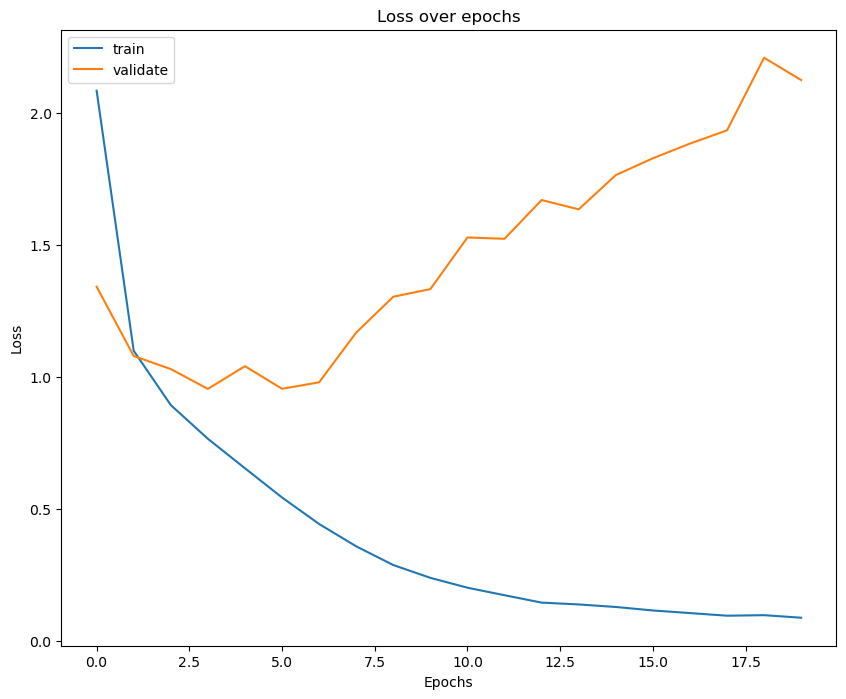

In [18]:
plot_history(history3)

In [ ]:
model3.save('model3.h5')